In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import t, norm, kendalltau
from scipy.stats.mstats import winsorize
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

Now we check the data for issues (correlation, NA variables etc.) and standardize where needed. We also plot the historical prices over time to find any apparent trends.

Date                     0
Electricity              0
WindUtilization          0
FossilFuelUtilization    0
NaturalGas               0
Coal                     0
Carbon                   0
dtype: int64
Date                     0
Electricity              0
WindUtilization          0
FossilFuelUtilization    0
NaturalGas               0
Coal                     0
Carbon                   0
dtype: int64


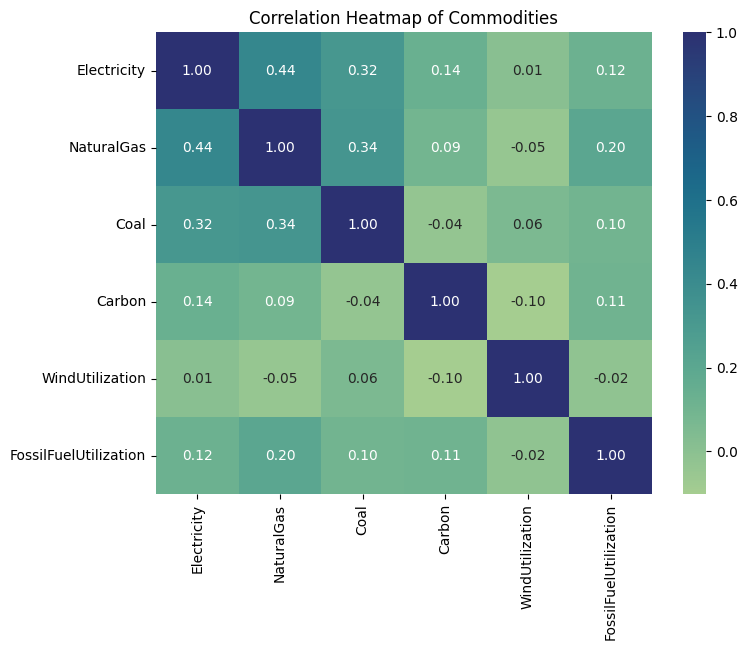

In [2]:
# Define the file path
file_path = "C:/Users/rijul/Desktop/Python/FinRisk Assignment/DataPost.xlsx"

# Load Excel sheets
return_data = pd.read_excel(file_path, sheet_name="Returns", parse_dates=["Date"])
price_data = pd.read_excel(file_path, sheet_name="Last_Price", parse_dates=["Date"])

# Check for missing values (project says they are gone but just confirming)
print(return_data.isnull().sum())
print(price_data.isnull().sum())

# Compute correlation matrix
cor_matrix = return_data[["Electricity", "NaturalGas", "Coal", "Carbon", "WindUtilization","FossilFuelUtilization"]].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cor_matrix, annot=True, cmap="crest", fmt=".2f")
plt.title("Correlation Heatmap of Commodities")
plt.show()

We see correlation between electricity and natural gas; however the low correlation of some types indicates that there is a possibility of diversification benefits by combining these assets. We explore this further later on.

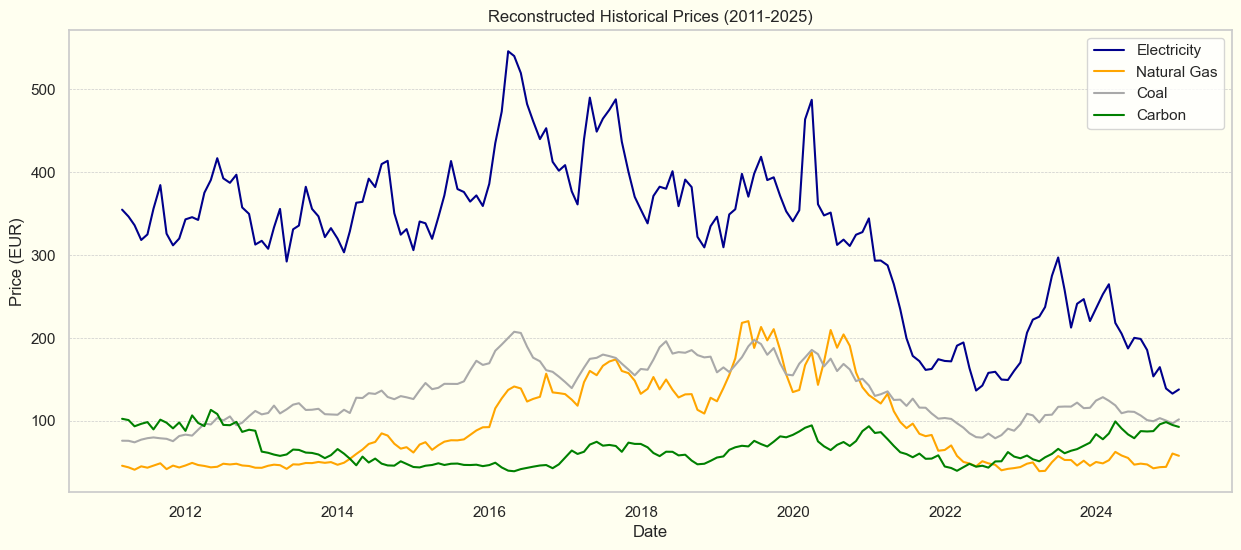

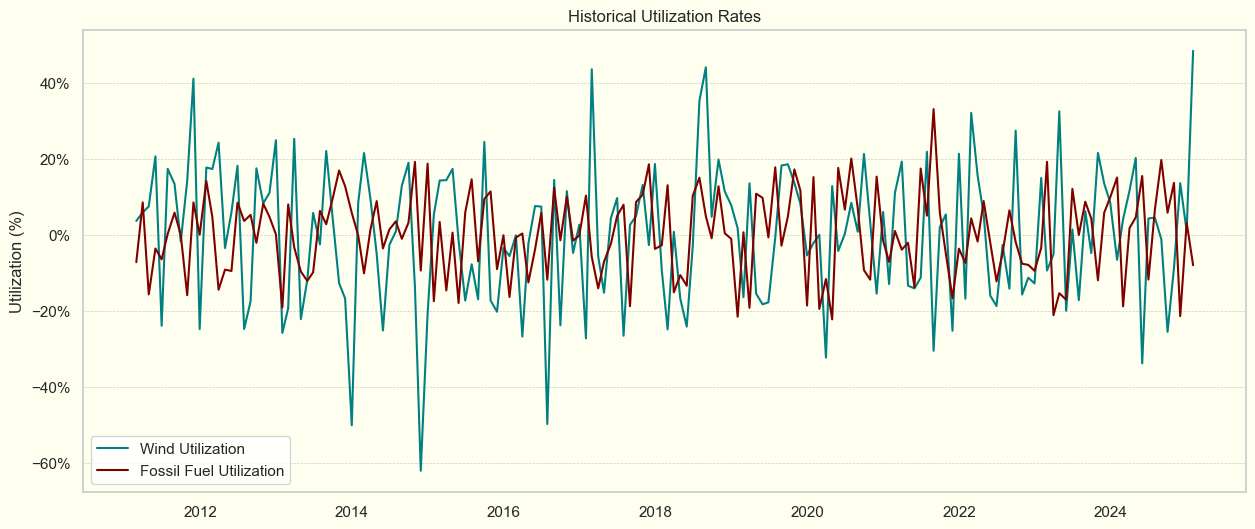

In [3]:
# Plotting Historical Returns
# Set the Seaborn style
sns.set(style="whitegrid")


# Extract last known prices (2025-01-31) from "Last_Price"
last_prices = price_data.iloc[0, 1:]  # Exclude the first column (date)

# Initialize DataFrame for historical prices
historical_prices = return_data.copy()

# Apply log returns cumulatively in **reverse** to reconstruct historical prices
for col in ["Electricity", "NaturalGas", "Coal", "Carbon"]:
    historical_prices[col] = last_prices[col] * np.exp(return_data[col][::-1].cumsum())

# Restore chronological order (earliest to latest)
historical_prices = historical_prices.sort_values("Date")

# Plot historical prices
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15,6), facecolor='ivory')
ax.set_facecolor('ivory')

ax.plot(historical_prices["Date"], historical_prices["Electricity"], label="Electricity", color="darkblue", linewidth=1.5)
ax.plot(historical_prices["Date"], historical_prices["NaturalGas"], label="Natural Gas", color="orange", linewidth=1.5)
ax.plot(historical_prices["Date"], historical_prices["Coal"], label="Coal", color="darkgray", linewidth=1.5)
ax.plot(historical_prices["Date"], historical_prices["Carbon"], label="Carbon", color="green", linewidth=1.5)

ax.set_title("Reconstructed Historical Prices (2011-2025)")
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR)")
ax.grid(True, linestyle='--', linewidth=0.5)  # Add a dashed grid for better separation
ax.xaxis.grid(False)  # Disable vertical grid lines
ax.legend()
plt.show()

# Create the utilization rate plot
fig, ax = plt.subplots(figsize=(15,6), facecolor='ivory')  # Set the background color to cream (ivory)
ax.set_facecolor('ivory')  # Set the axes background color to cream (ivory)
ax.plot(return_data["Date"], return_data["WindUtilization"] * 100, label="Wind Utilization",color="teal", linewidth=1.5)
ax.plot(return_data["Date"], return_data["FossilFuelUtilization"] * 100, label="Fossil Fuel Utilization",color="maroon", linewidth=1.5)
ax.set_ylabel("Utilization (%)")
ax.set_title("Historical Utilization Rates")
ax.legend()
ax.grid(True, linestyle='--', linewidth=0.5)  # Add a dashed grid for better separation
ax.xaxis.grid(False)  # Disable vertical grid lines

# Format y-axis labels as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

Key Takeaways: Both utilization rates and prices are extremely volatilite, there are some overlapping movements but not perfectly correlated, consistent with the risk heat map generated. The wind utilization rate is much more volatile, indicating a more unstable utilisation environment.

We now move on to forecast future prices. Bootstrapping (w/ Copula). We deem it suitable to forecast future prices using the Bootstrapping with Copula method as it accounts for correlation between different energy types. We winsorize only the very extreme outliers. We don't winsorize more as downside risk and volatility is a huge risk factor in this case, we want to preserve that in our forecasts.

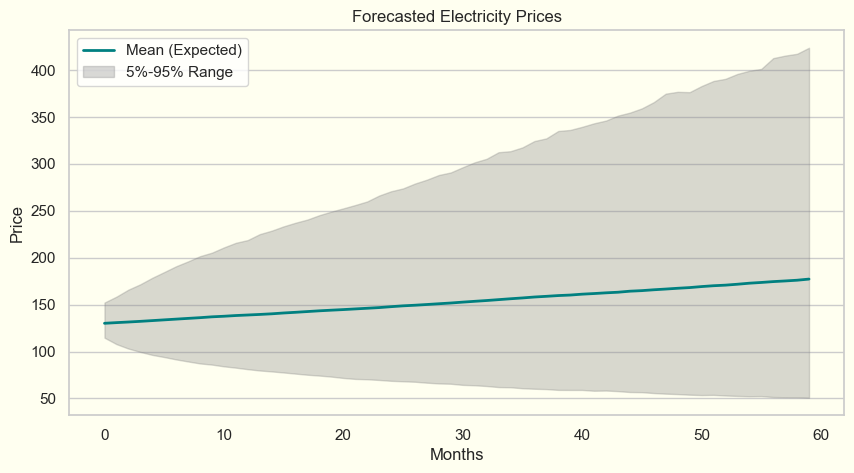

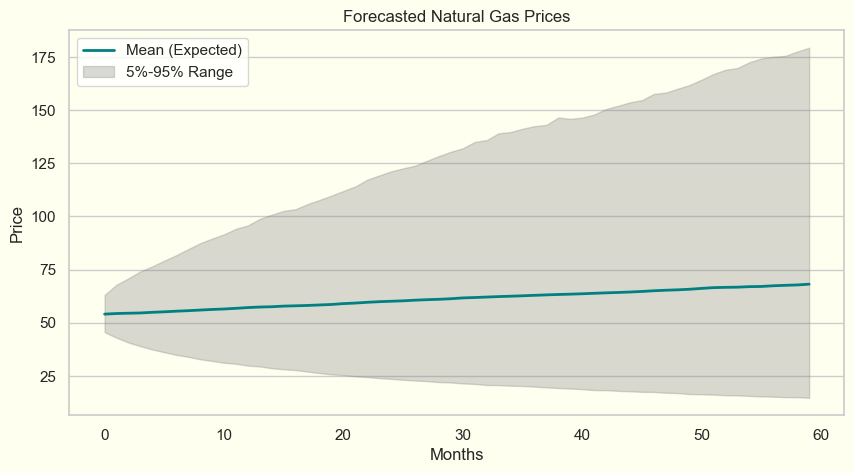

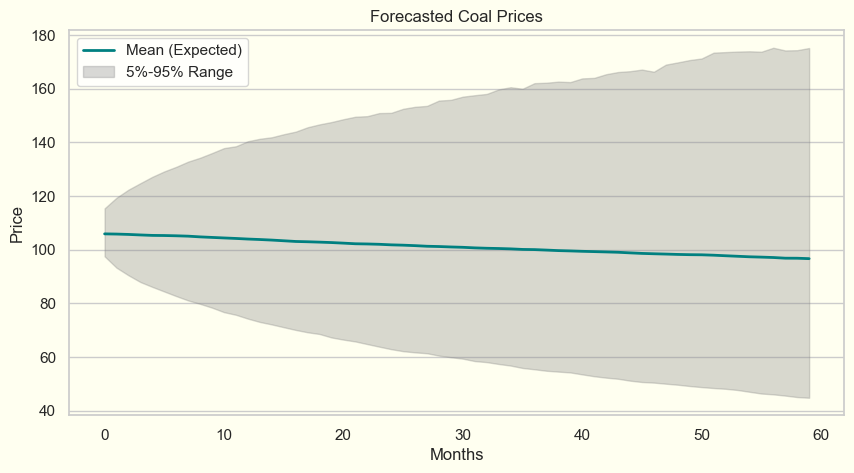

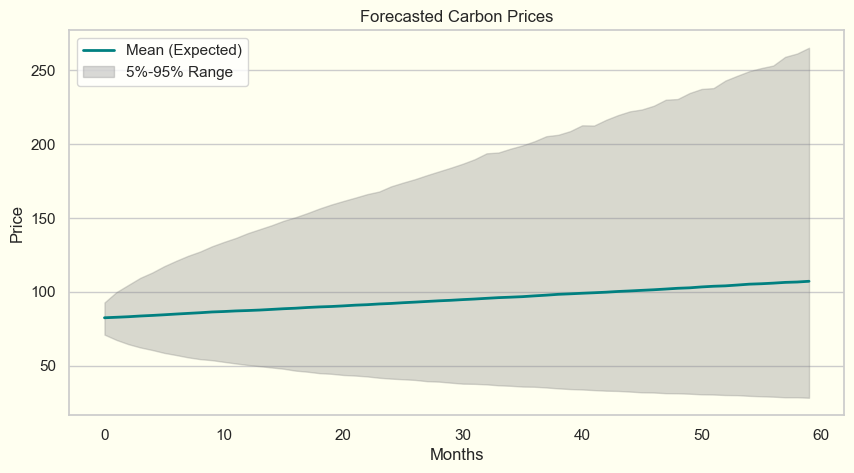

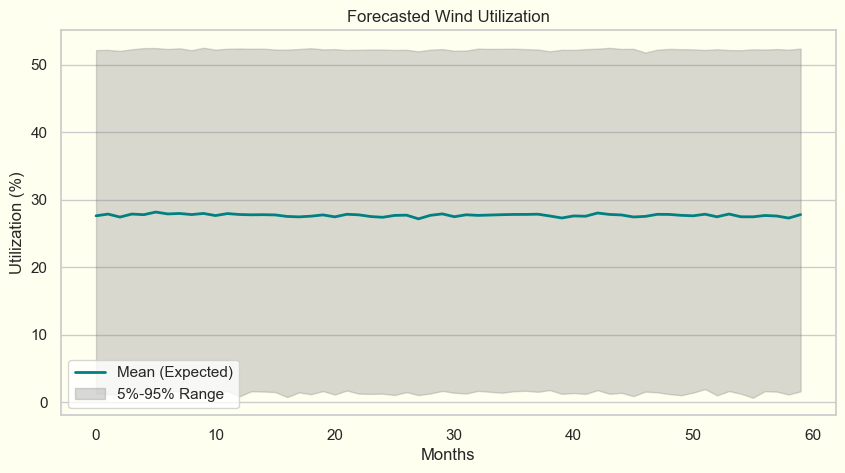

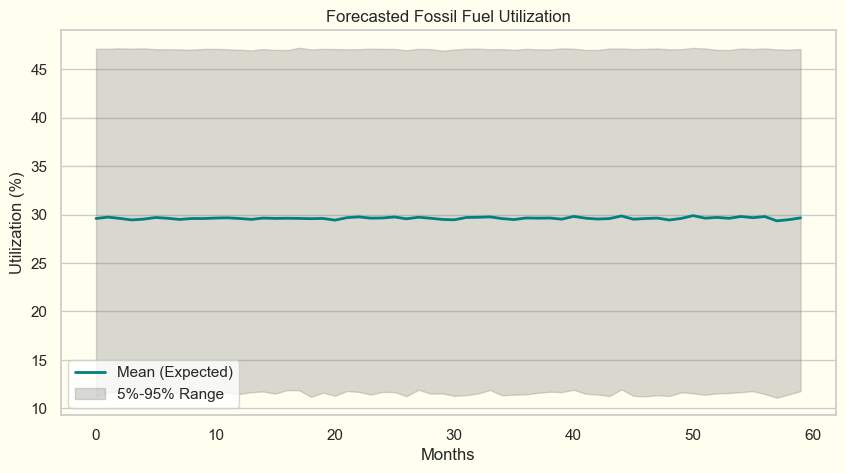

C:\Users\rijul\AppData\Local\Temp\ipykernel_30400\1347398025.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


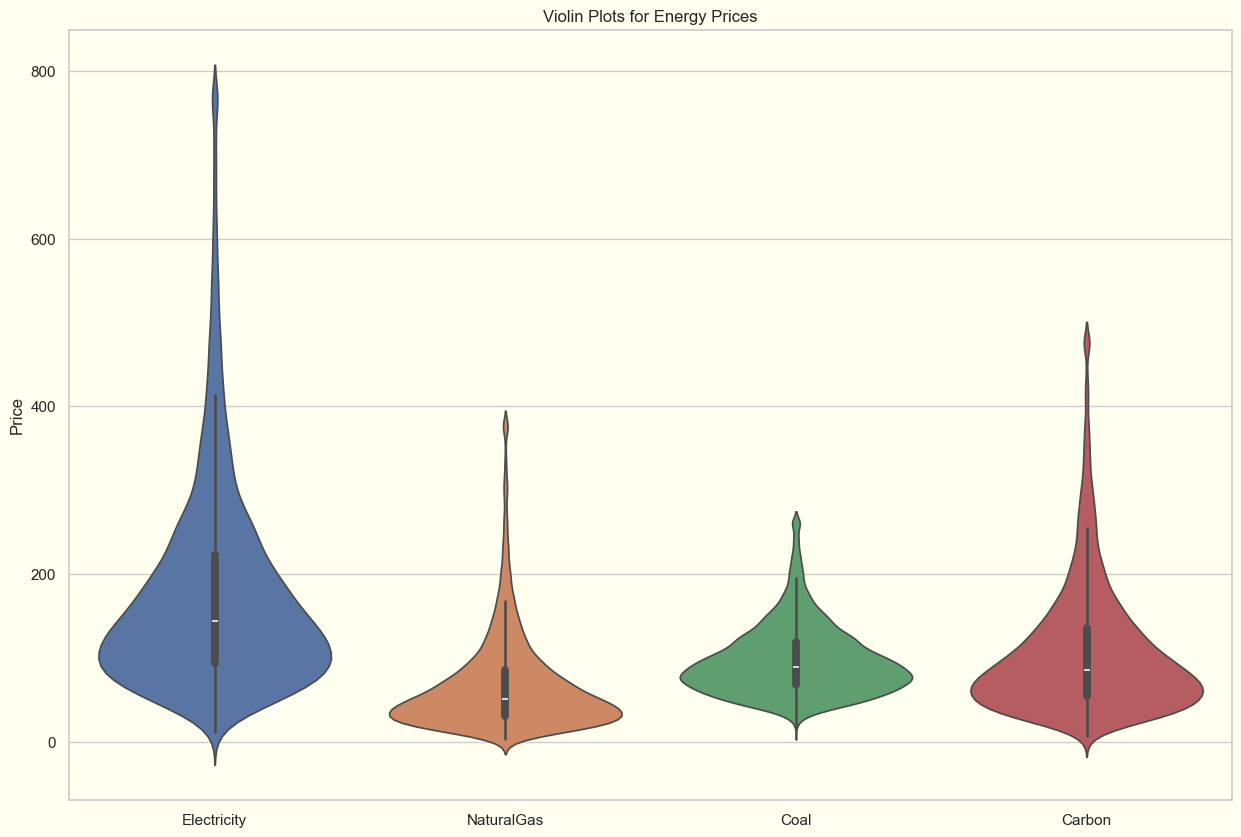

C:\Users\rijul\AppData\Local\Temp\ipykernel_30400\1347398025.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


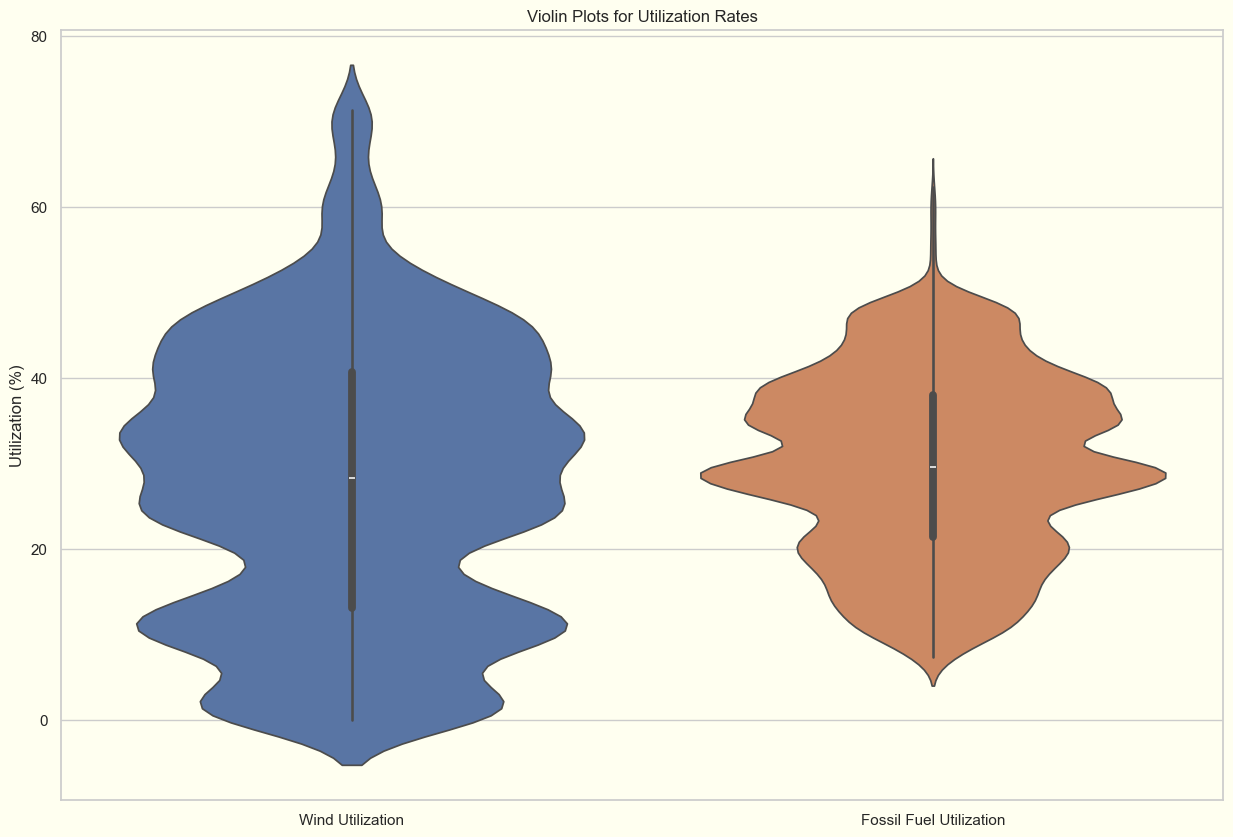

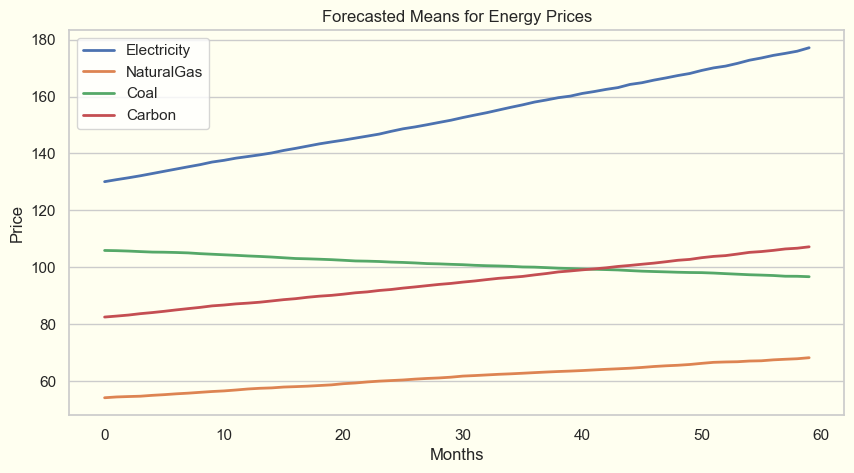

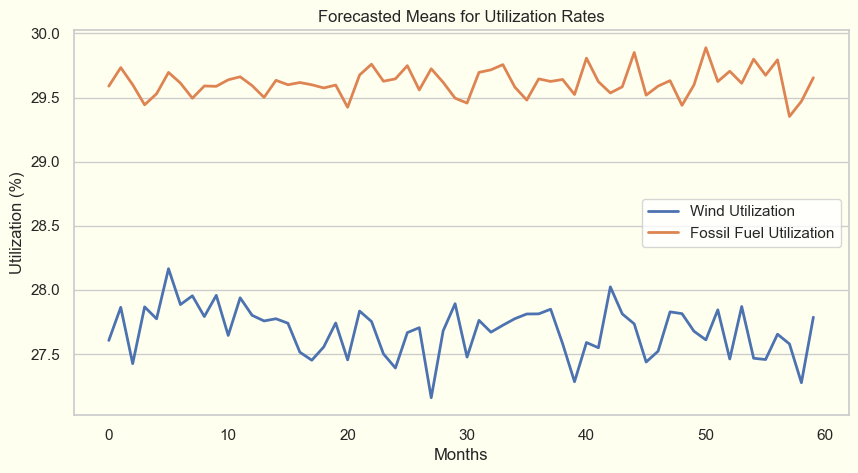

In [4]:
# Train on all historical data except the last 12 months, test on the most recent 12 months
train_data = return_data.iloc[:-12]  
test_data = return_data.iloc[-12:]  
    
# ===========================
# Step 3: Compute Copula-Based Correlations
# ===========================

# Compute Kendall’s Tau for rank correlations
kendall_matrix = train_data.loc[:, train_data.columns != 'Date'].corr(method='kendall')

# Convert Kendall’s Tau to Copula-Compatible Correlation using sin transformation
copula_correlation = np.sin(kendall_matrix * (np.pi / 2))

# ===========================
# Step 4: Generate Bootstrapped Copula Samples
# ===========================

# Number of simulations and forecast periods
forecast_months = 60
num_simulations = 10000
df_t = 10  # Degrees of freedom for Student-t transformation

# Generate Gaussian Copula Samples
Z = np.random.multivariate_normal(np.zeros(len(copula_correlation)), copula_correlation, size=(forecast_months, num_simulations))

# Transform Gaussian Samples to Uniform Distribution
U = norm.cdf(Z)

# Apply Student-t Transformation for Fat Tails
T_samples = t.ppf(U, df_t)

# ===========================
# Step 5: Map Bootstrapped Samples to Historical Data
# ===========================

# Initialize Dictionary for Simulated Returns
simulated_returns = {}
sorted_rets = {}

# Map Bootstrapped Copula Samples to Historical Distributions (Corrected Loop)
for i, col in enumerate(["Electricity", "NaturalGas", "Coal", "Carbon", "WindUtilization", "FossilFuelUtilization"]):
    # Sort the historical returns
    sorted_rets[col] = np.sort(train_data[col].values)

    # Ensure Copula samples are mapped to the correct variable
    percentiles = np.linspace(0, 100, len(sorted_rets[col]))
    simulated_returns[col] = np.percentile(
        sorted_rets[col], U[:, :, i].flatten() * 100
    ).reshape(forecast_months, num_simulations)

# ===========================
# Step 6: Convert Simulated Returns into Prices
# ===========================

# Get latest prices from the "Last_Price" sheet
latest_prices = price_data.iloc[-1]

# Convert Simulated Returns to Prices (Exponential Growth)
electricity_prices = latest_prices["Electricity"] * np.exp(np.cumsum(simulated_returns["Electricity"], axis=0))
electricity_prices = np.clip(electricity_prices, a_min=0.1, a_max=np.percentile(electricity_prices, 99.9))  # Clip extreme values

naturalgas_prices = latest_prices["NaturalGas"] * np.exp(np.cumsum(simulated_returns["NaturalGas"], axis=0))
naturalgas_prices = np.clip(naturalgas_prices, a_min=0.1, a_max=np.percentile(naturalgas_prices, 99.9))  # Clip extreme values

coal_prices = latest_prices["Coal"] * np.exp(np.cumsum(simulated_returns["Coal"], axis=0))
coal_prices = np.clip(coal_prices, a_min=0.1, a_max=np.percentile(coal_prices, 99.9))  # Clip extreme values

carbon_prices = latest_prices["Carbon"] * np.exp(np.cumsum(simulated_returns["Carbon"], axis=0))
carbon_prices = np.clip(carbon_prices, a_min=0.1, a_max=np.percentile(carbon_prices, 99.9))  # Clip extreme values

# Convert Utilization with Seasonal Adjustments
initial_wind_utilization = latest_prices["WindUtilization"]
initial_fossil_utilization = latest_prices["FossilFuelUtilization"]

wind_utilization = np.clip(initial_wind_utilization + simulated_returns["WindUtilization"], 0, 1)  # Adjust for seasonality
fossil_utilization = np.clip(initial_fossil_utilization + simulated_returns["FossilFuelUtilization"], 0, 1)

# ===========================
# Step 7: Compute Mean & Percentiles
# ===========================

def compute_forecast_percentiles(simulated_data):
    mean_series = np.mean(simulated_data, axis=1)
    percentile_5 = np.percentile(simulated_data, 5, axis=1)
    percentile_95 = np.percentile(simulated_data, 95, axis=1)
    return mean_series, percentile_5, percentile_95

# Compute for prices
electricity_mean, electricity_p5, electricity_p95 = compute_forecast_percentiles(electricity_prices)
naturalgas_mean, naturalgas_p5, naturalgas_p95 = compute_forecast_percentiles(naturalgas_prices)
coal_mean, coal_p5, coal_p95 = compute_forecast_percentiles(coal_prices)
carbon_mean, carbon_p5, carbon_p95 = compute_forecast_percentiles(carbon_prices)

# Compute for utilization
wind_mean, wind_p5, wind_p95 = compute_forecast_percentiles(wind_utilization * 100)
fossil_mean, fossil_p5, fossil_p95 = compute_forecast_percentiles(fossil_utilization * 100)

# ===========================
# Step 8: Plot Forecasts
# ===========================

def plot_forecast(mean_series, p5_series, p95_series, title, ylabel, is_percentage=False):
    fig, ax = plt.subplots(figsize=(10, 5), facecolor='ivory')
    ax.set_facecolor('ivory')
    ax.plot(mean_series, label="Mean (Expected)", color="teal", linewidth=2)
    ax.fill_between(range(len(mean_series)), p5_series, p95_series, color="gray", alpha=0.3, label="5%-95% Range")
    ax.set_xlabel("Months")
    ax.xaxis.grid(False)  # Disable vertical grid lines
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

# Plot prices
plot_forecast(electricity_mean, electricity_p5, electricity_p95, "Forecasted Electricity Prices", "Price")
plot_forecast(naturalgas_mean, naturalgas_p5, naturalgas_p95, "Forecasted Natural Gas Prices", "Price")
plot_forecast(coal_mean, coal_p5, coal_p95, "Forecasted Coal Prices", "Price")
plot_forecast(carbon_mean, carbon_p5, carbon_p95, "Forecasted Carbon Prices", "Price")

# Plot utilization
plot_forecast(wind_mean, wind_p5, wind_p95, "Forecasted Wind Utilization", "Utilization (%)", is_percentage=True)
plot_forecast(fossil_mean, fossil_p5, fossil_p95, "Forecasted Fossil Fuel Utilization", "Utilization (%)", is_percentage=True)

# ===========================
# Step 9: Violin Plots
# ===========================
# Combine violin plots for energy types into one graph
def plot_combined_violin(data_dict, title, ylabel):
    fig, ax = plt.subplots(figsize=(15, 10), facecolor='ivory')
    ax.set_facecolor('ivory')
    data = []
    labels = []
    for key, value in data_dict.items():
        data.append(value)
        labels.append(key)
    sns.violinplot(data=data, ax=ax)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    plt.show()

# Prepare data for violin plots
energy_prices_data = {
    "Electricity": electricity_prices[-1],
    "NaturalGas": naturalgas_prices[-1],
    "Coal": coal_prices[-1],
    "Carbon": carbon_prices[-1]
}

utilization_data = {
    "Wind Utilization": wind_utilization[-1] * 100,
    "Fossil Fuel Utilization": fossil_utilization[-1] * 100
}

# Plot combined violin plot for energy prices
plot_combined_violin(energy_prices_data, "Violin Plots for Energy Prices", "Price")

# Plot combined violin plot for utilization rates
plot_combined_violin(utilization_data, "Violin Plots for Utilization Rates", "Utilization (%)")

# ===========================
# Step 10: Combined Forecasted Means Plot
# ===========================
def plot_combined_forecast_means(mean_dict, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 5), facecolor='ivory')
    ax.set_facecolor('ivory')
    for key, value in mean_dict.items():
        ax.plot(value, label=key, linewidth=2)
    ax.set_xlabel("Months")
    ax.xaxis.grid(False)  # Disable vertical grid lines
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

# Prepare data for combined forecasted means plot
forecasted_means_prices = {
    "Electricity": electricity_mean,
    "NaturalGas": naturalgas_mean,
    "Coal": coal_mean,
    "Carbon": carbon_mean
}

forecasted_means_utilization = {
    "Wind Utilization": wind_mean,
    "Fossil Fuel Utilization": fossil_mean
}

# Plot combined forecasted means for prices
plot_combined_forecast_means(forecasted_means_prices, "Forecasted Means for Energy Prices", "Price")

# Plot combined forecasted means for utilization rates
plot_combined_forecast_means(forecasted_means_utilization, "Forecasted Means for Utilization Rates", "Utilization (%)")

Backtesting → Compare simulated vs. actual historical movements.

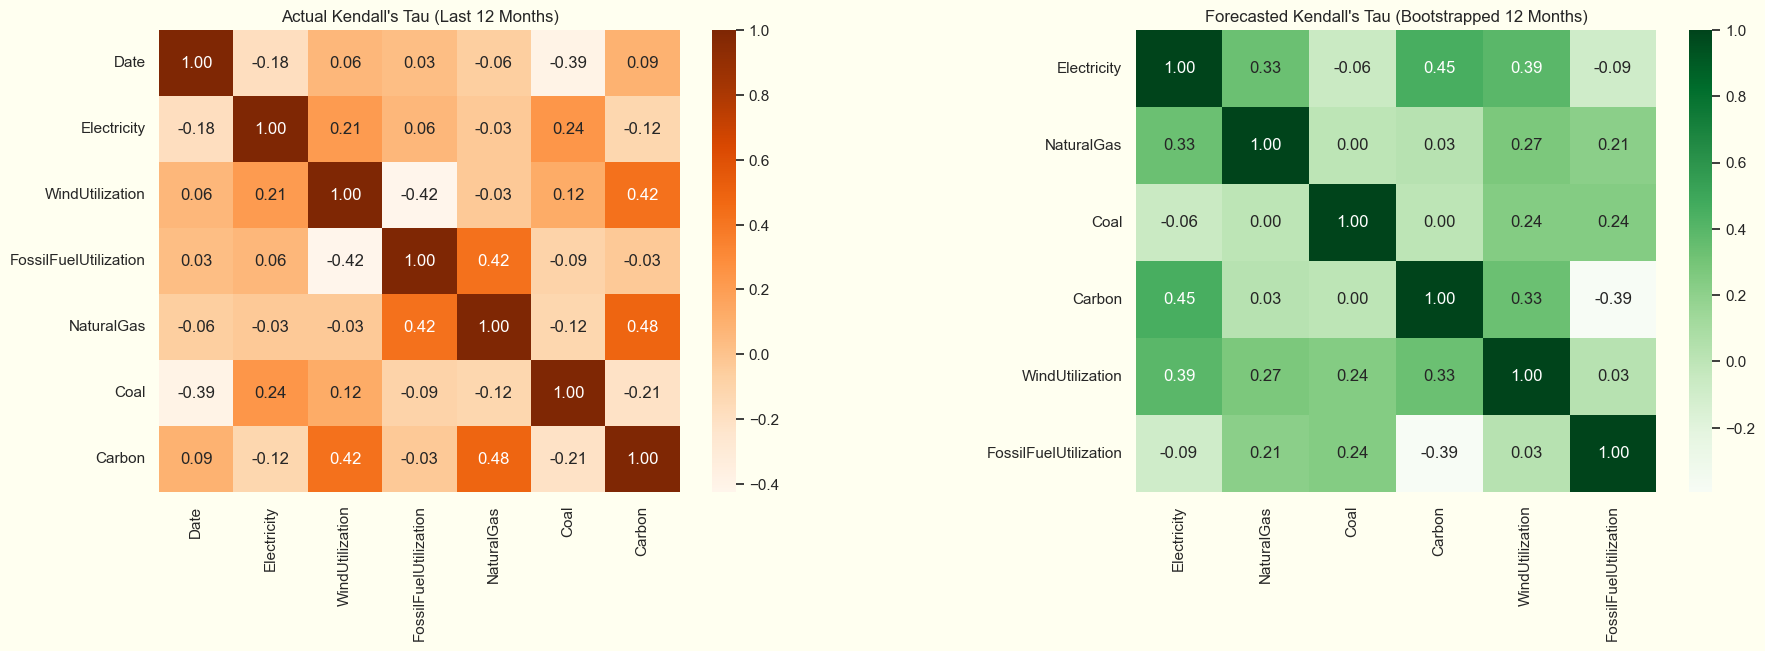

The historical correlation structure is closer to the actual out-of-sample correlation than the forecast.


In [5]:
# ===========================
# Step 1: Extract the first 12 months of the bootstrapped forecasted returns
# ===========================
forecast_horizon = 12  # Number of months to compare
num_simulations = 10000  # Number of simulations

# Convert dictionary to DataFrame
forecasted_returns_df = pd.DataFrame({
    "Electricity": simulated_returns["Electricity"][:forecast_horizon, :].mean(axis=1),
    "NaturalGas": simulated_returns["NaturalGas"][:forecast_horizon, :].mean(axis=1),
    "Coal": simulated_returns["Coal"][:forecast_horizon, :].mean(axis=1),
    "Carbon": simulated_returns["Carbon"][:forecast_horizon, :].mean(axis=1),
    "WindUtilization": simulated_returns["WindUtilization"][:forecast_horizon, :].mean(axis=1),
    "FossilFuelUtilization": simulated_returns["FossilFuelUtilization"][:forecast_horizon, :].mean(axis=1)
})

# ===========================
# Step 2: Compute Kendall’s Tau Correlations
# ===========================

# Historical Kendall's Tau (Training Data)
historical_kendall_tau = train_data.corr(method='kendall')

# Actual Out-of-Sample Kendall's Tau (Last 12 Months)
out_of_sample_kendall_tau = test_data.corr(method='kendall')

# Forecasted Kendall's Tau (First 12 Months of Bootstrapped Simulations)
forecasted_kendall_tau = forecasted_returns_df.corr(method='kendall')

# ===========================
# Step 3: Plot Heatmaps
# ===========================

fig, axes = plt.subplots(1, 2, figsize=(21, 6))
fig.set_facecolor("ivory")
fig.subplots_adjust(wspace=0.5)

sns.heatmap(out_of_sample_kendall_tau, annot=True, cmap="Oranges", fmt=".2f", ax=axes[0])
axes[0].set_title("Actual Kendall's Tau (Last 12 Months)")
axes[0].set_facecolor("ivory")

sns.heatmap(forecasted_kendall_tau, annot=True, cmap="Greens", fmt=".2f", ax=axes[1])
axes[1].set_title("Forecasted Kendall's Tau (Bootstrapped 12 Months)")
axes[1].set_facecolor("ivory")

plt.show()

# ===========================
# Step 4: Compute Kendall’s Tau Distance
# ===========================

def kendall_tau_distance(matrix1, matrix2):
    """
    Computes the Frobenius norm between two Kendall's Tau matrices.
    Measures the difference in correlation structures.
    """
    return np.linalg.norm(matrix1 - matrix2)

actual_vs_forecasted_distance = kendall_tau_distance(out_of_sample_kendall_tau, forecasted_kendall_tau)
actual_vs_historical_distance = kendall_tau_distance(out_of_sample_kendall_tau, historical_kendall_tau)

# Interpretation
if actual_vs_forecasted_distance < actual_vs_historical_distance:
    print("The bootstrapped forecast better matches the actual 12-month correlation structure than historical data.")
else:
    print("The historical correlation structure is closer to the actual out-of-sample correlation than the forecast.")

Our backtest works moderately effectively capturing SOME of the correlations, however not all are covered. Nevertheless, we move on to estimating cash flows and default risk for the project


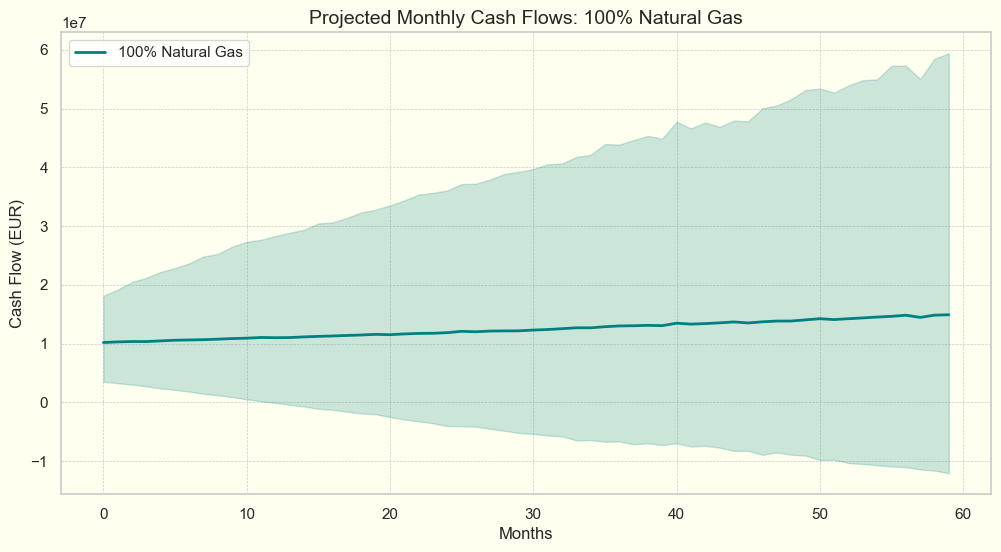

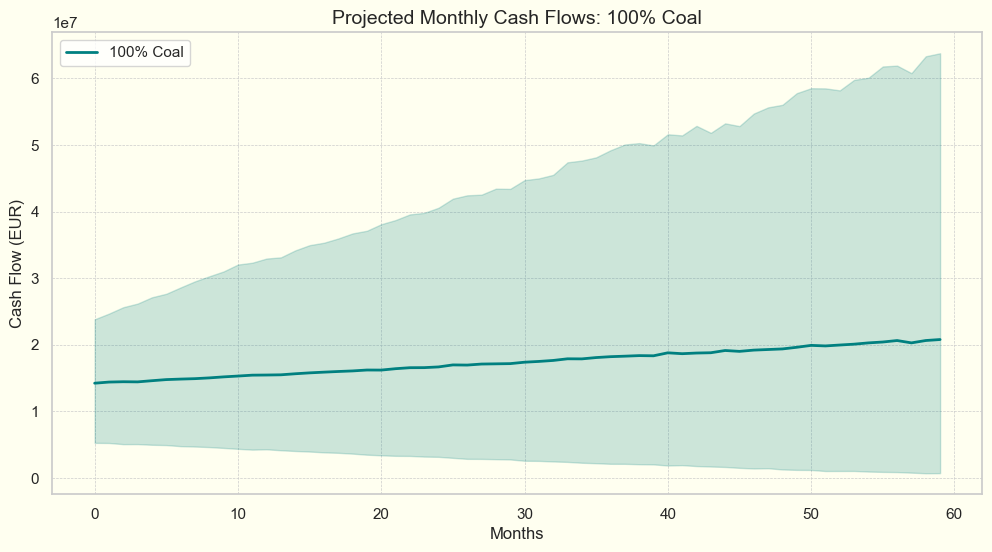

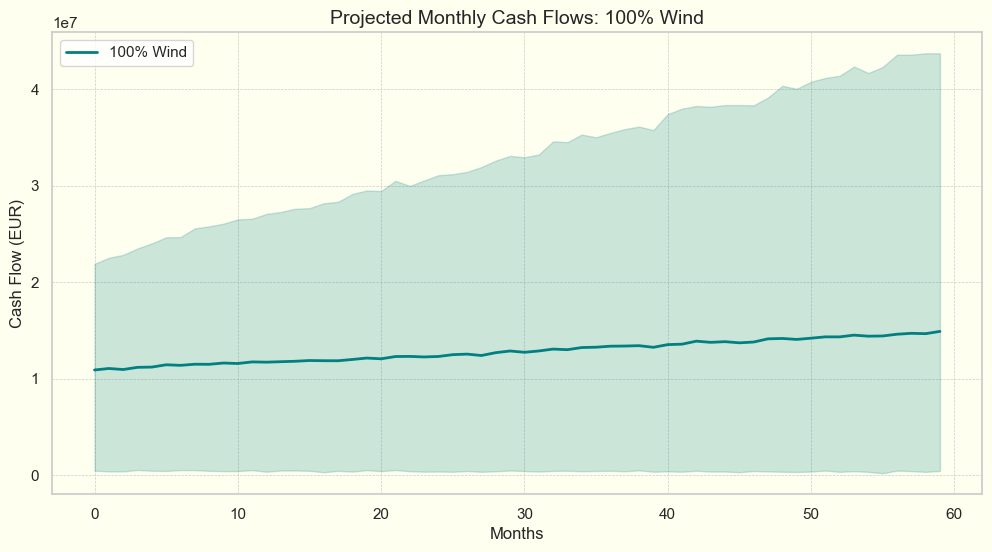

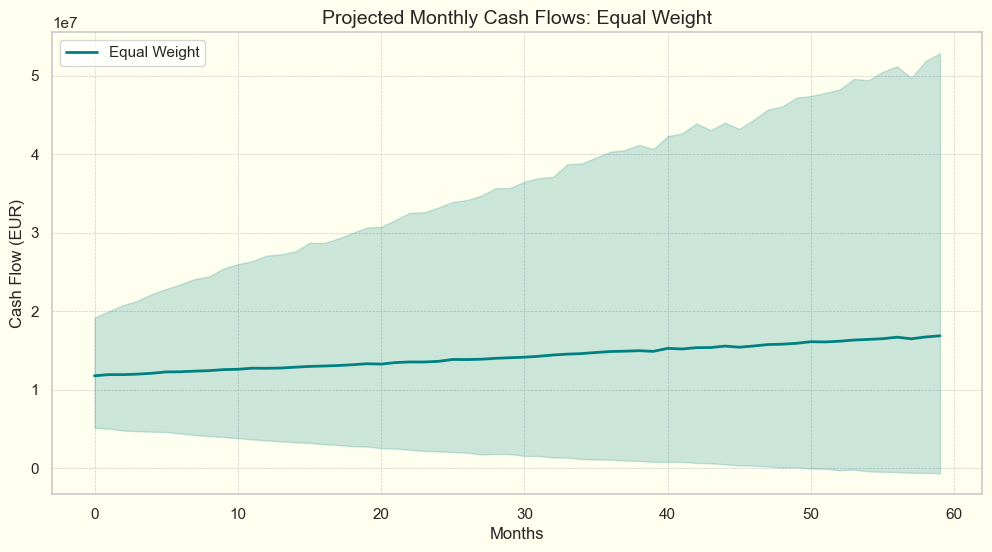

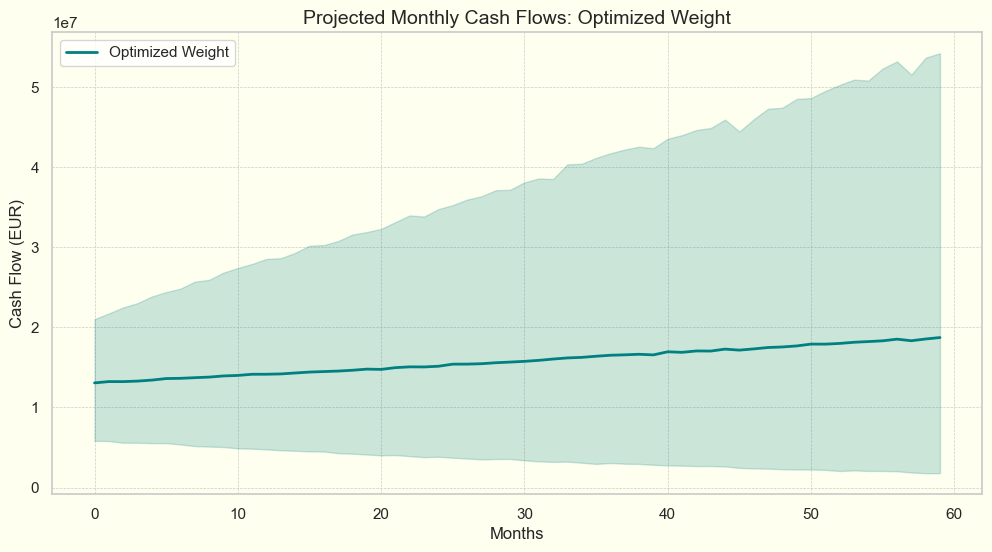

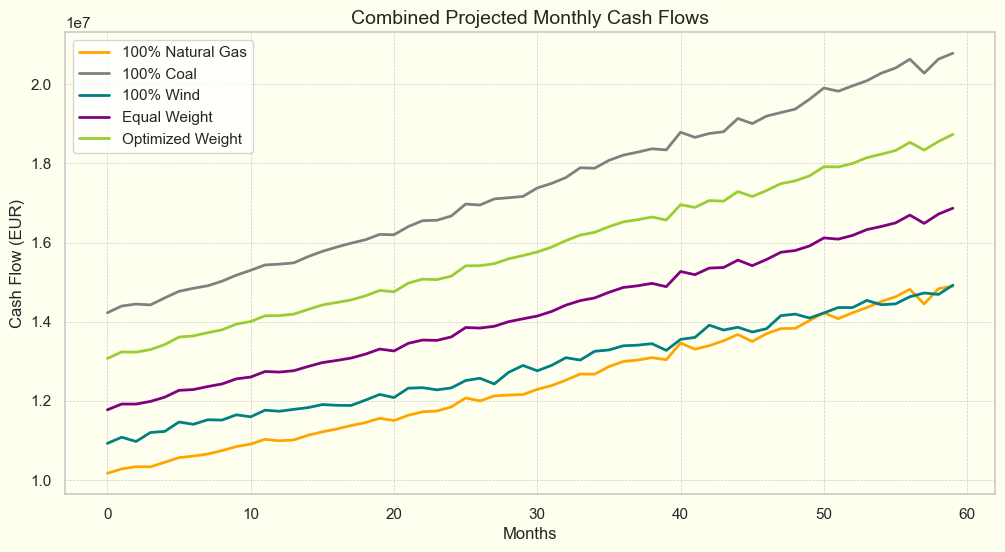

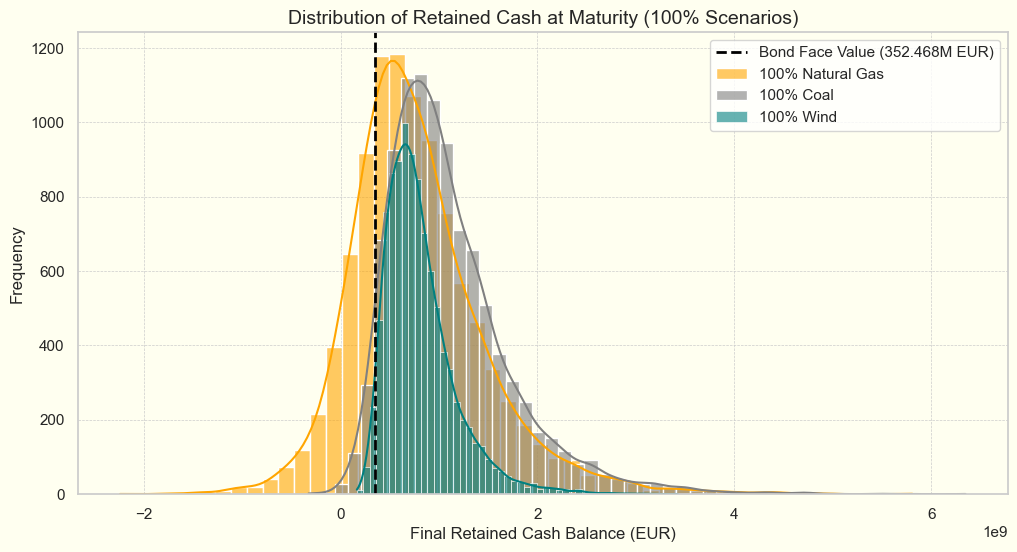

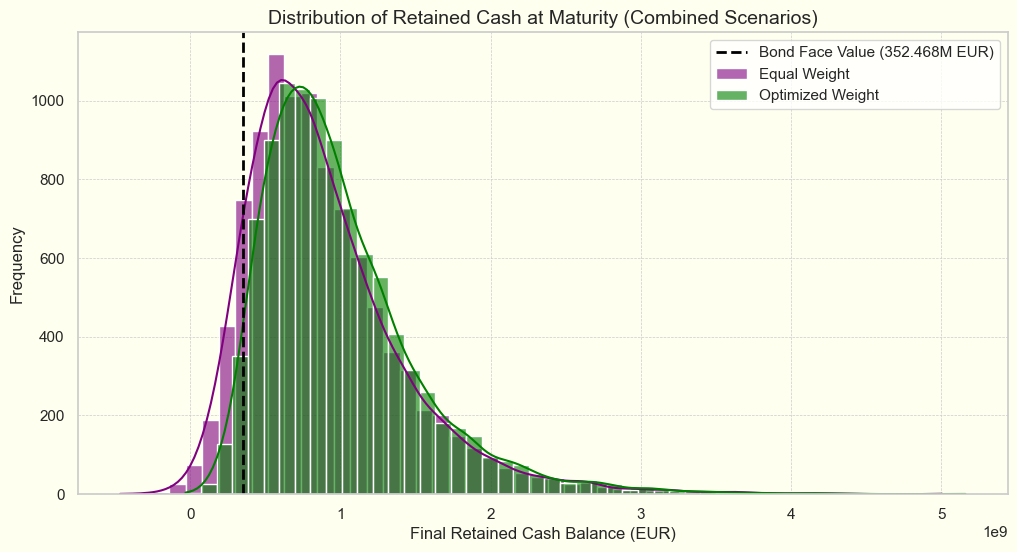

C:\Users\rijul\AppData\Local\Temp\ipykernel_30400\1509052423.py:232: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=probabilities, y=scenarios, ax=ax, palette="crest")
C:\Users\rijul\AppData\Local\Temp\ipykernel_30400\1509052423.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="", loc='upper right', fontsize=12)


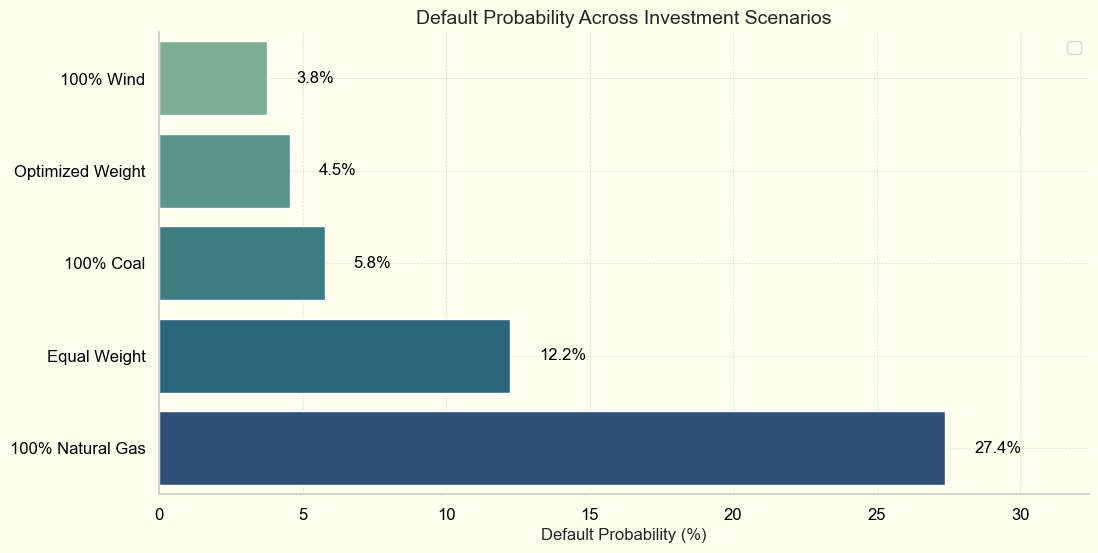

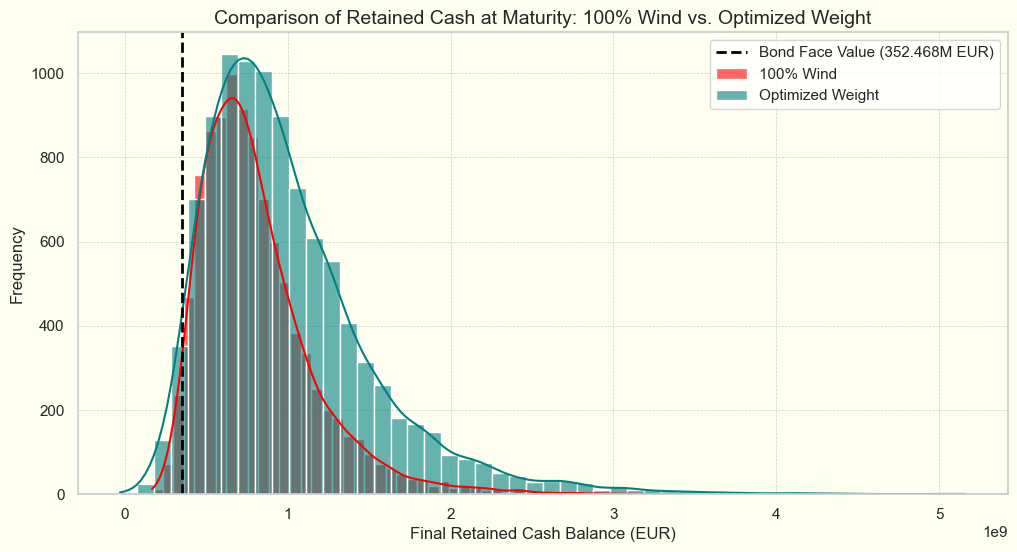

⚠️ 100% Wind | Max Loss at 95% Confidence: 112,997,846.22 EUR
⚠️ Optimized Weight | Max Loss at 95% Confidence: 194,740,460.96 EUR
⚠️ 100% Coal | Max Loss at 95% Confidence: 303,174,130.45 EUR
⚠️ Equal Weight | Max Loss at 95% Confidence: 329,720,250.84 EUR
⚠️ 100% Natural Gas | Max Loss at 95% Confidence: 352,468,000.00 EUR


C:\Users\rijul\AppData\Local\Temp\ipykernel_30400\1509052423.py:312: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=max_losses, y=scenarios, palette=seagreen_teal, ax=ax)


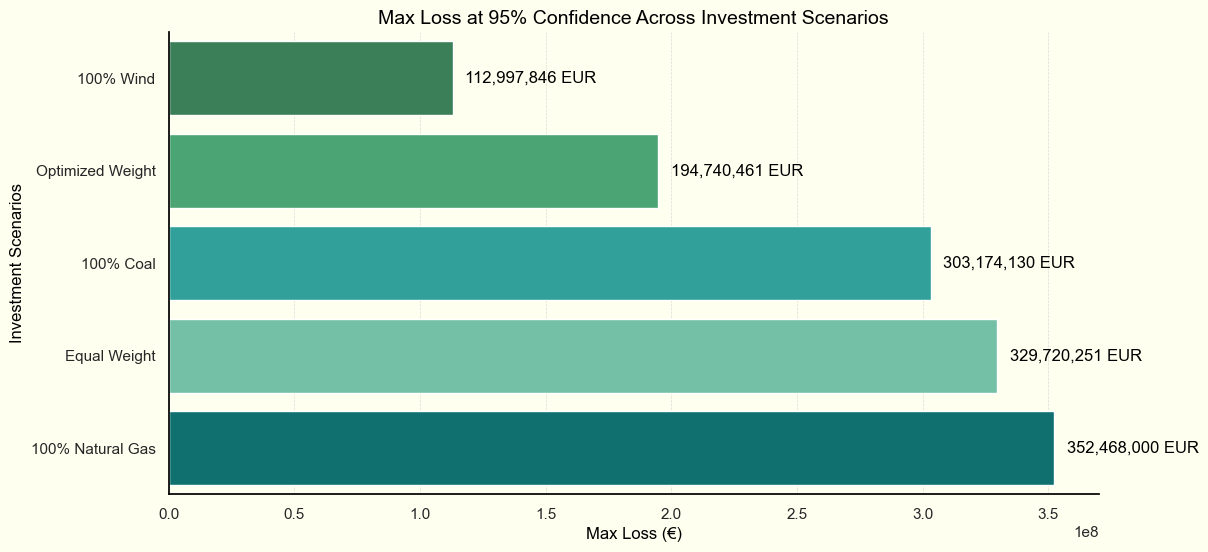

In [6]:
# ===========================
# Step 1: Load Forecasted Prices & Utilization (10,000 Simulations)
# ===========================

# Simulated price forecasts (10,000 simulations over 60 months)
forecasted_prices = {
    "Electricity": electricity_prices,  # 60 x 10,000
    "NaturalGas": naturalgas_prices,
    "Coal": coal_prices,
    "Carbon": carbon_prices
}

# Simulated utilization rates (10,000 simulations over 60 months)
forecasted_utilization = {
    "FossilFuelUtilization": fossil_utilization,  # 60 x 10,000
    "WindUtilization": wind_utilization
}

# ===========================
# Step 2: Investment Scenarios
# ===========================
scenarios = {
    "100% Natural Gas": {"NaturalGas": 1, "Coal": 0, "Wind": 0},
    "100% Coal": {"NaturalGas": 0, "Coal": 1, "Wind": 0},
    "100% Wind": {"NaturalGas": 0, "Coal": 0, "Wind": 1},
    "Equal Weight": {"NaturalGas": 1/3, "Coal": 1/3, "Wind": 1/3},
    "Optimized Weight": {"NaturalGas": 0, "Coal": 0.65, "Wind": 0.35}
}

# ===========================
# Step 3: Compute Capacity for Each Scenario
# ===========================

base_capacity = {
    "NaturalGas": 95,  # MWh/day per 1M invested
    "Coal": 100,       # MWh/day per 1M invested
    "Wind": 50         # MWh/day per 1M invested
}

total_investment = 200  # EUR million

scenario_capacities = {}

for scenario, weights in scenarios.items():
    scenario_capacities[scenario] = {
        energy: total_investment * weights[energy] * base_capacity[energy] * 30  # Convert to MWh per month
        for energy in weights.keys()
    }

# ===========================
# Step 4: Compute Monthly Revenue
# ===========================

scenario_revenues = {}

for scenario, capacities in scenario_capacities.items():
    scenario_revenues[scenario] = np.zeros((60, num_simulations))
    
    for energy in capacities.keys():
        actual_production = (
            capacities[energy] * forecasted_utilization["WindUtilization"] if energy == "Wind"
            else capacities[energy] * forecasted_utilization["FossilFuelUtilization"]
        )
        scenario_revenues[scenario] += actual_production * forecasted_prices["Electricity"]

# ===========================
# Step 5: Compute Monthly Costs
# ===========================

scenario_costs = {}

for scenario, capacities in scenario_capacities.items():
    scenario_costs[scenario] = np.zeros((60, num_simulations))
    
    for energy in capacities.keys():
        actual_production = (
            capacities[energy] * forecasted_utilization["WindUtilization"] if energy == "Wind"
            else capacities[energy] * forecasted_utilization["FossilFuelUtilization"]
        )

        fuel_cost = (
            actual_production * forecasted_prices["NaturalGas"] if energy == "NaturalGas"
            else (actual_production / 8) * forecasted_prices["Coal"] if energy == "Coal"
            else 0
        )

        o_and_m_cost = actual_production * {"NaturalGas": 0.015, "Coal": 0.10, "Wind": 0.20}[energy]

        carbon_emissions = actual_production * {"NaturalGas": 0.20, "Coal": 0.45, "Wind": 0}[energy]
        carbon_cost = carbon_emissions * forecasted_prices["Carbon"]

        scenario_costs[scenario] += fuel_cost + o_and_m_cost + carbon_cost

# ===========================
# Step 6: Compute Monthly Net Cash Flows
# ===========================

scenario_cash_flows = {scenario: scenario_revenues[scenario] - scenario_costs[scenario] for scenario in scenarios.keys()}

# ===========================
# Step 7: Compute Compounded Retained Cash (Monthly at 2%)
# ===========================

risk_free_rate = 0.02 / 12  # Monthly risk-free rate
bond_face_value = 352.468*1000000  # EUR million

scenario_retained_cash = {}

for scenario in scenarios.keys():
    retained_cash = np.zeros((60, num_simulations))
    retained_cash[0] = scenario_cash_flows[scenario][0]

    for t in range(1, 60):
        retained_cash[t] = (retained_cash[t-1] * (1 + risk_free_rate)) + scenario_cash_flows[scenario][t]

    scenario_retained_cash[scenario] = retained_cash

# ===========================
# Step 8: Compute Expected Monthly Cash Flows (Mean & Percentiles)
# ===========================

scenario_cash_flow_stats = {}

for scenario in scenarios.keys():
    scenario_cash_flow_stats[scenario] = {
        "Mean": np.mean(scenario_cash_flows[scenario], axis=1),
        "P5": np.percentile(scenario_cash_flows[scenario], 5, axis=1),
        "P95": np.percentile(scenario_cash_flows[scenario], 95, axis=1)
    }

# ===========================
# Step 9: Default Probability Estimation
# ===========================

scenario_default_probs = {
    scenario: np.mean(np.sum(scenario_cash_flows[scenario], axis=0) < bond_face_value) * 100 for scenario in scenarios.keys()
}

# ===========================
# Step 10: Plot Expected Monthly Cash Flows
# ===========================

for scenario in scenarios.keys():
    fig, ax = plt.subplots(figsize=(12, 6), facecolor="ivory")
    ax.set_facecolor("ivory")

    ax.plot(scenario_cash_flow_stats[scenario]["Mean"], label=scenario, linewidth=2, color="teal")
    ax.fill_between(range(60), scenario_cash_flow_stats[scenario]["P5"], scenario_cash_flow_stats[scenario]["P95"], color="teal", alpha=0.2)

    ax.set_title(f"Projected Monthly Cash Flows: {scenario}", fontsize=14)
    ax.set_xlabel("Months", fontsize=12)
    ax.set_ylabel("Cash Flow (EUR)", fontsize=12)
    ax.legend()
    ax.grid(True, linestyle="--", linewidth=0.5)

    plt.show()

# ===========================
# Step 10.1: Plot Combined Expected Monthly Cash Flows
# ===========================

fig, ax = plt.subplots(figsize=(12, 6), facecolor="ivory")
ax.set_facecolor("ivory")

colors_combined = {"100% Natural Gas": "orange", "100% Coal": "gray", "100% Wind": "teal", "Equal Weight": "purple", "Optimized Weight": "yellowgreen"}

for scenario in scenarios.keys():
    ax.plot(scenario_cash_flow_stats[scenario]["Mean"], label=scenario, linewidth=2, color=colors_combined[scenario])

ax.set_title("Combined Projected Monthly Cash Flows", fontsize=14)
ax.set_xlabel("Months", fontsize=12)
ax.set_ylabel("Cash Flow (EUR)", fontsize=12)
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.5)

plt.show()

# ===========================
# Step 11: Separate Histograms of Retained Cash at Maturity
# ===========================

# 100% investment scenarios
fig, ax = plt.subplots(figsize=(12, 6), facecolor="ivory")
ax.set_facecolor("ivory")

colors = {"100% Natural Gas": "orange", "100% Coal": "gray", "100% Wind": "teal"}

for scenario in ["100% Natural Gas", "100% Coal", "100% Wind"]:
    sns.histplot(scenario_retained_cash[scenario][-1], bins=50, kde=True, label=scenario, color=colors[scenario], alpha=0.6)

ax.axvline(x=bond_face_value, color="black", linestyle="--", linewidth=2, label="Bond Face Value (352.468M EUR)")

ax.set_title("Distribution of Retained Cash at Maturity (100% Scenarios)", fontsize=14)
ax.set_xlabel("Final Retained Cash Balance (EUR)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.5)

plt.show()

# Combined scenarios
fig, ax = plt.subplots(figsize=(12, 6), facecolor="ivory")
ax.set_facecolor("ivory")

colors_combined = {"Equal Weight": "purple", "Optimized Weight": "green"}

for scenario in ["Equal Weight", "Optimized Weight"]:
    sns.histplot(scenario_retained_cash[scenario][-1], bins=50, kde=True, label=scenario, color=colors_combined[scenario], alpha=0.6)

ax.axvline(x=bond_face_value, color="black", linestyle="--", linewidth=2, label="Bond Face Value (352.468M EUR)")

ax.set_title("Distribution of Retained Cash at Maturity (Combined Scenarios)", fontsize=14)
ax.set_xlabel("Final Retained Cash Balance (EUR)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.5)

plt.show()

# ===========================
# Step 12: Plotting Default Probabilities
# ===========================

fig, ax = plt.subplots(figsize=(12, 6), facecolor="ivory")
ax.set_facecolor("ivory")

# Sort scenarios by default probability
sorted_scenarios = sorted(scenario_default_probs.items(), key=lambda x: x[1])
scenarios, probabilities = zip(*sorted_scenarios)

# Use a horizontal bar chart instead
sns.barplot(x=probabilities, y=scenarios, ax=ax, palette="crest")

ax.set_title("Default Probability Across Investment Scenarios", fontsize=14)
ax.set_xlabel("Default Probability (%)", fontsize=12)

# Add percentage labels inside bars
for i, v in enumerate(probabilities):
    ax.text(v + 1, i, f"{v:.1f}%", color='black', va='center', fontsize=12)

# Improve readability
ax.set_xlim(0, max(probabilities) + 5)
ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Customize tick parameters
ax.tick_params(axis='x', colors='black', labelsize=12)
ax.tick_params(axis='y', colors='black', labelsize=12)

# Customize grid lines
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Customize legend
ax.legend(title="", loc='upper right', fontsize=12)

plt.show()


# ===========================
# Step 13: Separate Histograms of Retained Cash at Maturity
# ===========================

fig, ax = plt.subplots(figsize=(12, 6), facecolor="ivory")
ax.set_facecolor("ivory")

colors_comparison = {"100% Wind": "red", "Optimized Weight": "teal"}

for scenario in ["100% Wind", "Optimized Weight"]:
    sns.histplot(scenario_retained_cash[scenario][-1], bins=50, kde=True, label=scenario, color=colors_comparison[scenario], alpha=0.6)

ax.axvline(x=bond_face_value, color="black", linestyle="--", linewidth=2, label="Bond Face Value (352.468M EUR)")

ax.set_title("Comparison of Retained Cash at Maturity: 100% Wind vs. Optimized Weight", fontsize=14)
ax.set_xlabel("Final Retained Cash Balance (EUR)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.5)

plt.show()

# ===========================
# Step 14: Compute Max Losses at 95% Confidence
# ===========================
scenario_max_losses = {}


for scenario in scenarios:  # No need for .keys(), just iterate directly
    defaulted_cases = scenario_retained_cash[scenario][-1] < bond_face_value
    losses = np.maximum(bond_face_value - scenario_retained_cash[scenario][-1], 0)
    
    if np.sum(defaulted_cases) > 0:  # Ensure we have defaults to compute percentiles
        scenario_max_losses[scenario] = np.minimum(np.percentile(losses[defaulted_cases], 95), bond_face_value)
    else:
        scenario_max_losses[scenario] = 0  # No default, no loss

# Print Max Losses per Scenario
for scenario, loss in scenario_max_losses.items():
    print(f"⚠️ {scenario} | Max Loss at 95% Confidence: {loss:,.2f} EUR")

# Convert scenario_max_losses dictionary into lists for plotting
scenarios = list(scenario_max_losses.keys())
max_losses = list(scenario_max_losses.values())

# Define a seagreen teal color palette
seagreen_teal = ["#2E8B57", "#3CB371", "#20B2AA", "#66CDAA", "#008080"]

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor="ivory")
ax.set_facecolor("ivory")  # Set the background color

sns.barplot(x=max_losses, y=scenarios, palette=seagreen_teal, ax=ax)

# Customize the plot aesthetics
ax.set_title("Max Loss at 95% Confidence Across Investment Scenarios", fontsize=14, color="black")  # Title in black
ax.set_xlabel("Max Loss (€)", fontsize=12, color="black")
ax.set_ylabel("Investment Scenarios", fontsize=12, color="black")

# Add labels inside bars
for i, v in enumerate(max_losses):
    ax.text(v + 5_000_000, i, f"{v:,.0f} EUR", color='black', va='center', fontsize=12)

# Improve readability
ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")

# Display the plot
plt.show()



Now we move on to calculating the correct face value of the bond, valuing the derivative that hedges cash flow risk and explaining whether the firm should buy the derivative.

In [7]:
scenarios = {
    "100% Natural Gas": {"NaturalGas": 1, "Coal": 0, "Wind": 0},
    "100% Coal": {"NaturalGas": 0, "Coal": 1, "Wind": 0},
    "100% Wind": {"NaturalGas": 0, "Coal": 0, "Wind": 1},
    "Equal Weight": {"NaturalGas": 1/3, "Coal": 1/3, "Wind": 1/3},
    "Optimized Weight": {"NaturalGas": 0, "Coal": 0.65, "Wind": 0.35}
}
# Constants
investment = 200_000_000  # Initial investment (EUR)
annual_yield = 0.12  # Required annual return (12%)
discount_rate = 0.12 / 12  # Monthly expected return rate (annualized)
forecast_horizon = 60  # 5 years * 12 months

# ===========================
# Step 1: Solve for Face Value at 12% Expected Return
# ===========================
def bond_face_value_error(face_value, total_retained):
    """
    Objective function to minimize the difference between the expected annualized return 
    and the target yield of 12%.
    """
    repayments = np.clip(total_retained, 0, face_value)
    avg_return_rate = np.mean(repayments / investment) - 1  # Average return
    annualized_avg_return = (1 + avg_return_rate) ** (1/5) - 1  # Convert to annual return
    error = np.abs(annualized_avg_return - annual_yield)  # Absolute error for optimization

    return error

# Optimize face value for each scenario
scenario_corrected_face_values = {}

for scenario in scenarios.keys():
    result = minimize(
        lambda x: bond_face_value_error(x, scenario_retained_cash[scenario][-1]),
        x0=[investment],  
        bounds=[(50_000_000, 2_000_000_000)],  # Expanded bounds to prevent local minima
        method="Powell"  # More robust optimizer
    )
    scenario_corrected_face_values[scenario] = result.x[0]

# Print optimized bond face values
for scenario, fv in scenario_corrected_face_values.items():
    print(f"📌 {scenario} | Corrected Bond Face Value for 12% Return: {fv:,.2f} EUR")


# ===========================
# Step 2: Compute the Cost of a Derivative Guaranteeing No Negative Cash Flows
# ===========================
def apply_distress_cost(cash_flow_matrix, distress_rate=0.10):
    """ Adjust negative cash flows by applying a distress cost multiplier. """
    adjusted_cf = np.copy(cash_flow_matrix)
    adjusted_cf[adjusted_cf < 0] *= (1 + distress_rate)
    return adjusted_cf

def value_derivative(cash_flow_matrix, discount_rate=0.12, freq=12):
    """ Compute the cost of a derivative that eliminates negative cash flows. """
    n_months, n_sims = cash_flow_matrix.shape

    # Derivative payoff: If CF < 0, the payoff is the amount needed to bring it to 0
    payoff_matrix = np.maximum(-cash_flow_matrix, 0)

    # Compute per-period discount factor
    period_rate = (1 + discount_rate) ** (1 / freq) - 1
    discount_factors = (1 + period_rate) ** np.arange(n_months)

    # Compute expected discounted derivative cost
    discounted_sums = np.sum(payoff_matrix / discount_factors[:, None], axis=0)
    return np.mean(discounted_sums)

# Apply distress cost adjustments
distressed_cash_flows = {scenario: apply_distress_cost(scenario_cash_flows[scenario]) for scenario in scenarios.keys()}

# Compute derivative costs
scenario_derivative_cost = {scenario: value_derivative(distressed_cash_flows[scenario]) for scenario in scenarios.keys()}

# Print derivative cost per scenario
for scenario, cost in scenario_derivative_cost.items():
    print(f"💰 {scenario} | Cost of Hedging Negative Cash Flows (12% Discounted): {cost:,.2f} EUR")

📌 100% Natural Gas | Corrected Bond Face Value for 12% Return: 432,452,992.47 EUR
📌 100% Coal | Corrected Bond Face Value for 12% Return: 357,760,830.88 EUR
📌 100% Wind | Corrected Bond Face Value for 12% Return: 353,728,491.65 EUR
📌 Equal Weight | Corrected Bond Face Value for 12% Return: 366,803,422.67 EUR
📌 Optimized Weight | Corrected Bond Face Value for 12% Return: 355,337,989.62 EUR
💰 100% Natural Gas | Cost of Hedging Negative Cash Flows (12% Discounted): 34,996,996.99 EUR
💰 100% Coal | Cost of Hedging Negative Cash Flows (12% Discounted): 1,364,598.05 EUR
💰 100% Wind | Cost of Hedging Negative Cash Flows (12% Discounted): 0.00 EUR
💰 Equal Weight | Cost of Hedging Negative Cash Flows (12% Discounted): 2,888,184.82 EUR
💰 Optimized Weight | Cost of Hedging Negative Cash Flows (12% Discounted): 363,809.08 EUR
